# Distributed Computing Inspired by Biology

This notebook showcases the different distributed algorithms discussed in
> Függer, M., Nowak, T., Thuillier, K. (2025). Distributed Computing Inspired by Biology. Seminars in Cell and Developmental Biology.

It requires the *Python 3* packages: `numpy`, `networkx`, `scipy`, `mobspy`, `ipykernel`, and `ipywidgets`.
A virtual *Python 3* environment with all dependencies can be installed with:
```bash
python3 -m venv .venv
source .venv/bin/activate
pip install -r requirements.txt
```

It can also be executed online (*without any installation*), using *Binder* [![Binder](https://mybinder.org/badge_logo.svg)](https://mybinder.org/v2/gh/BioDisCo/dc_bio/HEAD).

In [1]:
from numpy import cos, pi, sin

from src.notebook_utils import *  # noqa: F403


In the cells below, the `Animation` checkboxes can be used to display step-by-step the iterations of the different algorithms.  
⚠️ **Warning:** Those animations may take some time to run. ⚠️

## Agreement Among Agents

This section presents the consensus algorithms discussed in the paper.
Agents and their communications are typically modeled using *communication graphs*, *i.e.*, directed graphs.
A node is an agent, and an edge is a potential communication between two agents.
In practice, communication graphs are often dynamic, changing over time.

Given an initial system state where each agent holds its own local value, consensus algorithms enable agents to iteratively update their states to eventually agree on a common value.  
To simplify notation, let's assume that the local value of agent $i$ is a set $X_i = \{ x_1, x_2, \cdots\}, \quad x_j \in \mathbb{R}^n$.
We also denote by $\delta^+_{G_k}(i)$ the set of neighboors of agent $i$ in the communication graph $G_k$

In this notebook (as in the paper), we consider two types of iterations:

1. *standard iteration*:  
    Each node/agent updates its local value according to its neighboors' (in the current communication graph) local values.  
    The local value of agent $i$ is updated *w.r.t.* an update function $f$ such that: 
    $$
        X_i := f(X_i \cup \bigcup_{j \in \delta^+_{G_k}(i)}  X_j)
    $$
    
2. *flooding iteration*:  
    Each node/agent sends its local value to its neighbors.  
    The local value of agent $i$ is updated such that: 
    $$
        X_i := X_i \cup \bigcup_{j \in \delta^+_{G_k}(i)}  X_j
    $$


**Outlines.** In the next subsections, we first generate the communication graphs sequence.
Then, we describe four algorithms / update functions: *equal-weight* (1D), *midpoints* (1D), *midextremes* (2D), and *approachextremes* (2D).

For each algorithm, we compare the convergence with and without *flooding iterations*.
In the following interactive cells, `flooding step` denotes the number of *flooding iterations* between two *standard iterations*.
Initial local values are randomized.

> See `src/consensus.py` for full implementation details.


### Graph Generation

We begin by generating a sequence of communication graphs for the consensus algorithms.  
To do so, we randomly generate $m$ rooted directed graphs with $n$ nodes.
Let $\mathcal{G} = \{ G_i \}_{i=1}^{m}$ denote this set of random rooted directed graphs.  
The communication graph sequence is then constructed by randomly sampling $l$ graphs from $\mathcal{G}$.

In [2]:
graphs, sequence = interact_consensus_graphs()  # noqa: F405

### 1D Methods

This subsection is dedicated to one dimensional local values.

#### Equal-weight

Given $X = \{ x_j \}_j$ for $x_j \in \mathbb{R}$, the update function is the mean of all values:
$$
    f_\text{equal-weight}(X) = \left \{ \frac{\sum_{x\in X} x }{|X|} \right \}
$$

The interactive cell belows show the local value of each node for each iteration of the consensus algorithm. 

In [3]:
interact_consensus_1D(sequence, "mean")  # noqa: F405

#### Midpoint

Given $X = \{ x_j \}_j$ for $x_j \in \mathbb{R}$, the update function is:
$$
    f_\text{midpoint}(X) = \left \{ \frac{\min(X) + \max(X) }{2} \right \}
$$

The interactive cell belows show the local value of each node for each iteration of the consensus algorithm. 

In [4]:
interact_consensus_1D(sequence, "midpoint")  # noqa: F405

#### Butterfly Graph

In [17]:
from src.consensus import *

num_nodes = 10

butterfly_graph = generate_butterfly_graph(num_nodes=num_nodes)

sequence = generate_graphs_sequence(graphs=[butterfly_graph], num=10)

init_values_1D = {node: {0 if node <= num_nodes//2 else 1} for node in butterfly_graph.nodes()}

interact_consensus_1D(sequence=sequence, method="mean", init_values_1D=init_values_1D)  # noqa: F405




### 2D Methods: MidExtreme vs ApproachExtreme

This subsection is dedicated to $n$-dimensional local values.
For the sake of our example, $n = 2$.

#### MidExtreme

Given $X = \{ x_j \}_j$ for $x_j \in \mathbb{R}^n$, the update function is:
$$
    f_\text{midextreme}(X) = \left \{ \frac{\arg\max_{(x, y) \in X \times X} ||x - y||_2 }{2} \right \}
$$
This function returns a new set of local values containing exactly one point: the midpoint between the two most distant points among all values currently held by the agent and its neighbors.

The interactive cell belows show the local value of each node for each iteration of the consensus algorithm. 

In [6]:
interact_consensus_2D(sequence, "midextreme")  # noqa: F405

#### ApproachExtreme

Given $X = \{ x_j \}_j$ for $x_j \in \mathbb{R}^n$ and $x \in \mathbb{R}^n$ the local value of the agent to update, the update function is:
$$
    f_\text{approachextreme}(x, X) = \left \{ \frac{\arg\max_{y \in X} ||x - y||_2 }{2} \right \}
$$
Unlike for *midextreme*, this function returns a new set of local values containing exactly one point: the midpoint between the current agent's local value and the point most distant from it among all values held by its neighbors and values received during flooding.

The interactive cell belows show the local value of each node for each iteration of the consensus algorithm. 

In [7]:
interact_consensus_2D(sequence, "approachextreme")  # noqa: F405

## Optimization by Agents

This section presents the optimization methods discussed in the paper.  

### Graph optimization: Maximal Independent Set

Given an undirected graph $G = (V, E)$ where $V$ is the set of vertices and $E \subseteq V \times V$ is the set of edges, a *maximal independent set* (MIS), denoted by $\text{MIS}(G)$ is a subset of $V$ such that:
1. no two nodes that are neighbors in the graph are in the MIS, *i.e.*, $\forall (u, v) \in E, \left(u \not \in \text{MIS}(G) \right) \lor \left(v \not \in \text{MIS}(G) \right)$;
2. the MIS is superset maximal, *i.e.*, no node can be added to the set without invalidating the first property.

Inspired from fly's cells communications to form sensory bristles, a bio-inspired MIS algorithm has been developed.  
> Yehuda Afek, Noga Alon, Omer Barad, Eran Hornstein, Naama Barkai, and Ziv Bar-Joseph. A Biological Solution to a Fundamental Distributed Computing Problem.  
> Science, 331(6014):183–185, January 2011. Publisher: American Association for the Advancement of Science.

This iterative algorithm works as follow.
At each iteration:

1. Each agent broadcasts a single bit message to their neighbors with a probability $p$ or remain silent. The probability $p$ increase through time.  
    For our implementation, we use $p = \frac{1}{2}^{\log{C} - i}$ with $C = \max_{v \in V} |\{u | \u \in V \land (u, v) \in E \}|$ (*i.e.*, maximum degree in the graph) and $i$ the current iteration, as proposed in the aformentionned paper.

2. An agent that has sent a message and does not receive any joins the MIS.

It has been proved (in the aformentionned paper) that after a sufficiently large number of iterations, the algorithm generate a MIS with high probability.
Note that it always ensures that no two neighboring nodes join the set.
In practice, we fixe the number of iteration at $20 \times \lceil \log(C) \rceil$ as proposed in the aformentionned paper.

In the cell below, the MIS algorithm is applied to a lattice graph.

> See `src/maximal_independent_set.py` for full implementation details.

In [8]:
interact_maximal_independent_set()  # noqa: F405

### General Loss Functions

Let's consider the general case where we want to optimize a given function $f$.

For our examples, we consider the function $f : \mathbb{R}^2 \to \mathbb{R}$ defined as:
$$
    f(x, y) = \sin(\pi \cdot x) \cdot \cos(\pi \cdot y) + (x^2 + y^2)
$$

In [9]:
def f(x: float, y: float) -> float:  # noqa: D103
    return sin(pi * x) * cos(pi * y) + (x**2 + y**2)

#### Differential Evolution

Differential Evolution is an optimization method that iteratively estimates the optimum of a real-valued function $f$.  
At each iteration, it generates new population of improving candidate solutions using three steps: *mutation* $\rightarrow$ *recombination* $\rightarrow$ *selection*.


**Algorithm outlines**  

* **Initialization:**  
    Randomly sample $n \in \mathbb{N}^*$ points in the solution space (referred to as `Population` below). 
    Let $X^{(0)} = \left \{x^{(0)}_j \right \}_{j = 1}^n$ be our initial population.
    
* **Iteration:**  
    For each iteration $i \geq 0$, the next population $X^{(i+1)} = \left \{ x_j^{(i+1)} \right \}_{j=1}^{n}$ is generated from $X^{(i)}$ as follows:
    1. **Mutation:**  
        For each individual $x_j^{(i)}$, randomly select three distinct individuals $x_{r1}^{(i)}$, $x_{r2}^{(i)}$, and $x_{r3}^{(i)}$ from the population.
        Construct a mutant vector:
        $$
            v^{(i+1)}_j = x^{(i)}_{r1} + \mu \cdot (x^{(i)}_{r2} - x^{(i)}_{r3})
        $$
        where $\mu \in \mathbb{R}^+$ is the mutation rate (referred to as `Mutation` below).
    
    2. **Recombination:**  
        Create a candidate vector by mixing components of $x_j^{(i)}$ and $v_j^{(i+1)}$.
        For each component $k$:
        $$
            v^{(i+1)}_{j,k} := \begin{cases} v^{(i+1)}_{j,k} & \text{with probability } \phi \\ x^{(i)}_{j,k} & \text{with probability } 1 - \phi \end{cases}
        $$
        where $\phi \in [0, 1]$ is the recombination rate (referred to as `Recombination` belows).

    3. **Selection:**  
        Keep the candidate individual that yields the lowest loss *w.r.t.* $f$:
        $$
            x^{(i+1)}_{j} = \begin{cases} v^{(i+1)}_{j} & \text{if } f(v^{(i+1)}_{j}) \leq f(x^{(i)}_{j}) \\ x^{(i)}_{j} & \text{otherwise} \end{cases}
        $$

> See `src/differential_evolution.py` for full implementation details.

In [10]:
interact_differential_evolution(f)  # noqa: F405

#### Particle Swarm Optimization

Particle Swarm Optimization is a stochastic optimization method.
It is used to find the global minimum (or maximum) of a real-valued function over a continuous space.

Here, each candidate solution is a particle moving through the search space.
At each iteration, particles adjust their position based on their momentum, the best value they found, and the best value found by all neighboring particles.


**Algorithm outlines**  
Given $n$ the number of particles, we denote by $x^{(i)}_j$ and $\nu^{(i)}_j$ the position and velocity of particle $j$, *respectively*, at the $i$-th iteration.
We also denote by $p^{(i)}_j$ the best position found by particle $j$ so far (***personal best***), and by $g$ the best position found by the entire swarm (***global best***).

* **Initialization:**  
    For all particles $j$: $x^{(0)}_j$ is randomly chosen in the solution space; $\nu^{(0)}_j = 0$; and $p^{(0)}_j = x^{(0)}_j$.  
    The global best value $g$ is initialized as $g = p^{(0)}_{\argmax_j f(p^{(0)}_j)}$.

* **Iteration:**  
    For all particles $j$:
    - Position and velocity updates *w.r.t.* personal and global bests.
        $$
            \begin{align*}
                \nu^{(i+1)}_j &= \rho \cdot \nu^{(i)}_j + w_p \cdot X^{(i)}_{j} \cdot (p^{(i)}_j - x^{(i)}_j)  + w_g \cdot Y^{(i)}_{j} \cdot (g - x^{(i)}_j) \\
                x^{(i+1)}_j &= x^{(i)}_j + \nu^{(i+1)}_j
            \end{align*}
        $$
        where $X^{(i)}_{j}, Y^{(i)}_{j} \sim \mathcal{N}(0, 1)$ are two random vectors, $\rho$ is the momentum rate, and $w_p, w_g \in \mathbb{R}^+$ are the attraction strengths toward the personal and global bests, *respectively*.

    - Personal and global best updates.
        $$
            p^{(i+1)}_j := \begin{cases} x^{(i+1)}_{j} & \text{if } f(x^{(i+1)}_{j}) \leq f(p^{(i)}_{j}) \\ p^{(i)}_{j} & \text{otherwise} \end{cases}
            \quad \quad \quad \quad
            g := \begin{cases} p^{(i+1)}_{j} & \text{if } f(p^{(i+1)}_{j}) \leq f(g) \\ g & \text{otherwise} \end{cases} \\
        $$


> See `src/particle_swarm.py` for full implementation details.

In [11]:
interact_particle_swarm(f)  # noqa: F405

### Differentiable Loss Functions: Gradient Descent

When the function to optimize is differentiable, gradient descent can be used to iteratively minimize it.
In gradient descent, the parameters are updated in the direction opposite to the gradient of the loss function ($- \frac{\partial f(\theta^{(i)})}{\theta^{(i)}}$).  
Let $0 < \tau \ll 1$ be the learning rate, let $f$ be the loss function, and let $\theta^{(i)}$ be the parameters of $f$ at the $i$-th iteration.
At each iteration $i$, the parameters $\theta^{(i)}$ are updated as follows:
$$
    \theta^{(i+1)} := \theta^{(i)} - \tau \cdot \frac{\partial f(\theta^{(i)})}{\theta^{(i)}}
$$

For the examples, we consider the differentiable function $f : \mathbb{R}^2 \to \mathbb{R}$ defined by:
$$
    f(x, y) = \sin(\pi \cdot x) \cdot \cos(\pi \cdot y) + (x^2 + y^2)
$$
whose derivatives are:
$$
    \begin{align*}
        \frac{\partial f(x, y)}{\partial x} &=  \pi \cdot \cos(\pi \cdot x) \cdot \cos(\pi \cdot y) + 2 \cdot x
        \quad\quad\quad\quad\quad 
        & \frac{\partial f(x, y)}{\partial y} &= -\pi \cdot \sin(\pi \cdot x) \cdot \sin(\pi \cdot y) + 2 \cdot y
    \end{align*}
$$

In [12]:
def f(x: float, y: float) -> float:  # noqa: D103
    return sin(pi * x) * cos(pi * y) + (x**2 + y**2)


def df_dx(x: float, y: float) -> float:  # noqa: D103
    return pi * cos(pi * x) * cos(pi * y) + 2 * x


def df_dy(x: float, y: float) -> float:  # noqa: D103
    return -pi * sin(pi * x) * sin(pi * y) + 2 * y

The paper discusses 3 variants of the gradient descent: *standard* gradient descent, a variant *with momentum*, and a variant *with noisy step*.  
For each method the iteration from $\theta^{(i)}$ to $\theta^{(i+1)}$ is given by:
1. **Standard:** 
    * $\theta^{(i+1)} := \theta^{(i)} - \tau \cdot \frac{\partial f(\theta^{(i)})}{\theta^{(i)}}$

2. **With momentum:**  
    This variant introduces a velocity vector $\nu_\theta^{(i)}$ to incorporate past updates into the current step.
    Let $\rho \in [0, 1]$ be the momentum rate (referred to as `Momentum` below).  
    Initialize $\nu_\theta^{(0)} = 0$, then update as:
    * $\nu^{(i+1)}_\theta := \rho \cdot \nu^{(i)}_{\theta} - \tau \cdot \frac{\partial f(\theta^{(i)})}{\theta^{(i)}}$
    * $\theta^{(i+1)} := \theta^{(i)} + \nu^{(i+1)}_{\theta}$

3. **With noise:**  
    This variant introduces Gaussian noise every $n$ steps to help escape local minima.  
    Let $n \in \mathbb{N}$ be the number of iterations between random steps (referred to as `Noise` below), and let $X^{(i)} \sim \mathcal{N}(0, 1)$ be a standard Gaussian vector.  
    At each iteration $i > 0$:
    * $\theta^{(i+1)} := \theta^{(i)} - \tau \cdot \begin{cases} X^{(i)} & \text{if } i \equiv 0 \pmod{n} \\ \frac{\partial f(\theta^{(i)})}{\theta^{(i)}} & \text{otherwise} \end{cases}$

> See `src/gradient_descent.py` for full implementation details.

In [13]:
interact_gradient_descent(f, df_dx, df_dy)  # noqa: F405

## Competing Neuron Models: the Hodgkin-Huxley Model

Mammalian brains contain a large number of neurons that interact to enable complex behavior.
An early, simple model of a neuron is the Hodgkin-Huxley model introduced in
> Alan L Hodgkin and Andrew F Huxley. A quantitative description of membrane current and its application to conduction and excitation in nerve.  
> The Journal of physiology, 117(4):500, 1952

It describes the kinetics of the membrane potential over time, for a given input current density.
The model is in terms of a system of non-linear \emph{ordinary differential equations} (ODEs) that describe the charging and discharging of a capacitance.
An arguably simplistic model of a single neuron with an input current density $I(t)$ and a resulting membrane potential $V(t)$ is described by
$$
    \begin{align*}
    I(t) &= \left \{ \begin{array}{l} \text{threshold} \times \text{factor} \quad \text{if } 10.0 \leq t \\ 0 \quad \text{else} \end{array} \right . \\
    C \cdot \frac{dV(t)}{dt} &= I(t) - I_\text{K}(V(t)) - I_\text{Na}(V(t)) - I_\text{L}(V(t)) \quad \quad \text{with } V(t_0) = V_0
    \end{align*}
$$
as the charging of a capacitance $C$ by $I$.
The non-linear discharging current densities of the sodium, potassium, and leak channels are described by
$$
\begin{align*}
    I_\text{Na}(V) &= g_\text{Na} \cdot m^3(t) \cdot h(t) \cdot (V - V_\text{Na})\\
    I_\text{K}(V) &= g_\text{K} \cdot n^4(t) \cdot h(t) \cdot (V - V_\text{K})\\
    I_\text{L}(V) &= g_\text{L} \cdot (V - V_\text{L})
\end{align*}
$$
where the dynamics of $m(t)$, $n(t)$, and $h(t)$ are defined by
$$
\begin{align*}
    \frac{dm(t)}{dt} &= \alpha_m(V(t)) \cdot (1 - m(t)) - \beta_m(V(t)) \cdot m(t) \quad & \text{with } m(t_0) = m_0 \\
    \frac{dn(t)}{dt} &= \alpha_n(V(t)) \cdot (1 - n(t)) - \beta_n(V(t)) \cdot n(t) \quad & \text{with } n(t_0) = n_0 \\
    \frac{dh(t)}{dt} &= \alpha_h(V(t)) \cdot (1 - h(t)) - \beta_h(V(t)) \cdot h(t) \quad & \text{with } h(t_0) = h_0
\end{align*}
$$
and $\alpha$ and $\beta$ are scaled and shifted exponential functions of $V(t)$.

> See `src/hodgkin_huxley.py` for full implementation details.

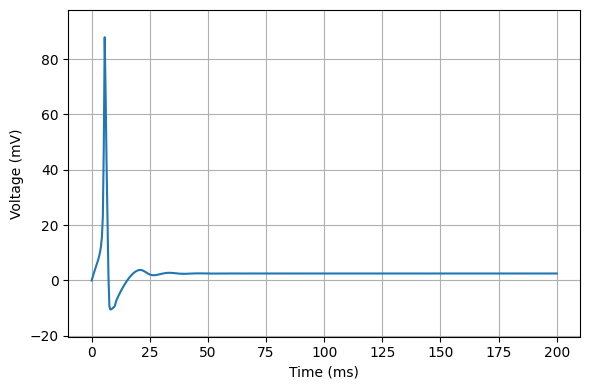

In [14]:
interact_hodgkin_huxley(duration=200, steps=500)  # noqa: F405

## Biology Inspired by Distributed Computing -- Chemical Reaction Networks

Inspired by distributed computing, researchers are recently starting to implement distributed algorithms into biological systems.
Chemical reaction networks are a mathematical model for reaction kinetics.
In particular, it is used to model the dynamics of biological systems. 

This section shows the simulations, deterministic and stochastic, of two chemical reaction networks: a simple model `ABC`, and a model of *mutual annihilation* `MutualAnnihilation` inspired from distributed algorithms.  

> See `src/chemical_reaction_network.py` for full implementation details.

### ABC Model

This model is composed of 3 biological entities `A`, `B`, and `C`, and 2 reactions:
$$
    \begin{align*}
        A + B &\rightarrow A + C &\quad[k_1]\\
        A &\rightarrow \emptyset &\quad [k_2]
    \end{align*}
$$

The associated ODE system is:
$$
    \begin{align*}
        \frac{\partial A(t)}{\partial t} &= -k_2 \cdot A(t)\\
        \frac{\partial B(t)}{\partial t} &= -k_1 \cdot A(t) \cdot B(t)\\
        \frac{\partial C(t)}{\partial t} &=  k_1 \cdot A(t) \cdot B(t)
    \end{align*}
$$
with $A(t_0) = A_0$, $B(t_0) = B_0$, and $C(t_0) = C_0$.

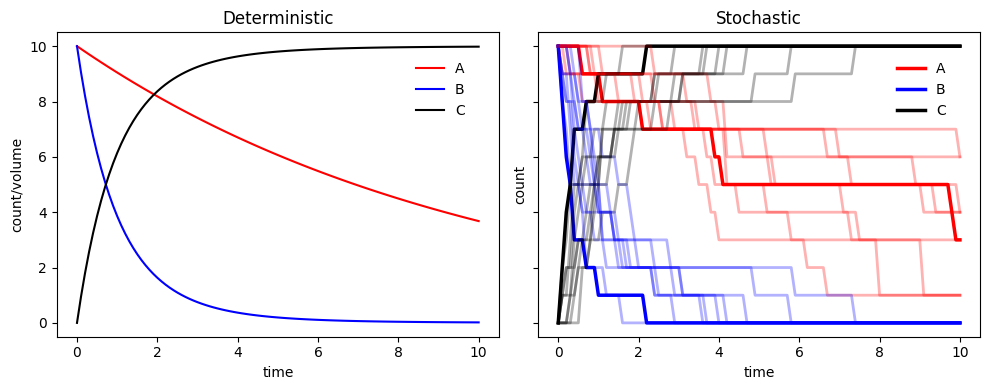

In [15]:
interact_crn_abc(duration=10)  # noqa: F405

### Mutual Annihilation Model

This model is composed of 3 biological entities `A`, `B`, and `R` (for the available ressources), and 4 reactions:
$$
    \begin{align*}
    A + B &\rightarrow A &\quad[k_1]\\
    A + B &\rightarrow B &\quad[k_2]\\
    A + R &\rightarrow A + A &\quad [k_3]\\
    B + R &\rightarrow B + B &\quad [k_4]
    \end{align*}
$$
This biological model is inspired by distributed algorithms, namely *voting algorithms*.
At the end of the simulation, only the entity that was initially in the majority (`A` or `B`) remains.

The associated ODE system is:
$$
    \begin{align*}
        \frac{\partial A(t)}{\partial t} &= -k_2 \cdot A(t) \cdot B(t) + k_3 \cdot A(t) \cdot R(t) \\
        \frac{\partial B(t)}{\partial t} &= -k_1 \cdot A(t) \cdot B(t) + k_4 \cdot B(t) \cdot R(t) \\
        \frac{\partial R(t)}{\partial t} &= -k_3 \cdot A(t) \cdot R(t) -k_4 \cdot B(t) \cdot R(t)
    \end{align*}
$$
with $A(t_0) = A_0$, $B(t_0) = B_0$, and $R(t_0) =R$.

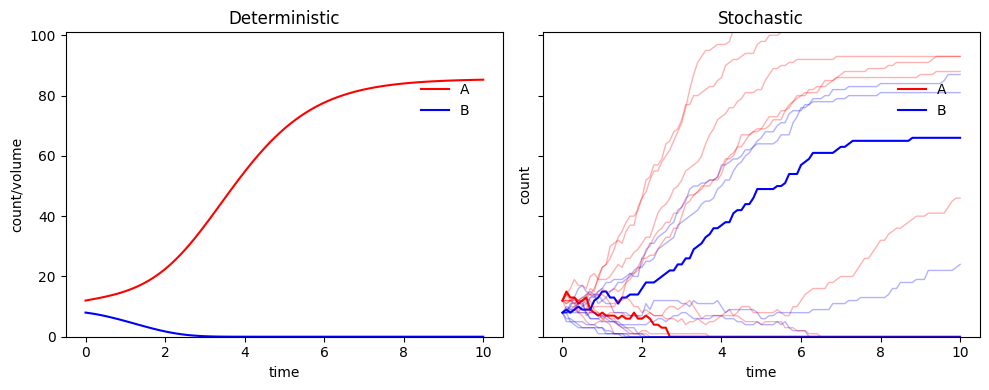

In [16]:
interact_crn_mutual_annihilation(duration=10)  # noqa: F405